In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from google.colab import files
uploaded = files.upload()


Saving test.csv to test.csv
Saving train.csv to train.csv


In [5]:

train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

In [6]:
print(train.shape, test.shape)

(22750, 9) (12250, 8)


In [7]:
burn_rate = train['Burn Rate']

In [8]:
employee_id  = test['Employee ID']

In [9]:
X  = pd.concat([train.drop(['Burn Rate'],axis=1),test],axis=0)

In [10]:
burn_rate1 =  burn_rate.fillna(burn_rate.median())

In [11]:
X['Mental Fatigue Score'].fillna(X['Mental Fatigue Score'].median(),inplace=True)

In [12]:
X['Resource Allocation'].fillna(X['Resource Allocation'].median(),inplace=True)

In [13]:
## Pandas Way
today=pd.datetime.today()
today

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


datetime.datetime(2020, 11, 15, 17, 45, 52, 261162)

In [14]:
dates = pd.to_datetime(X['Date of Joining'])
type(dates)

pandas.core.series.Series

In [15]:
diff = today-dates

In [16]:
diff = diff/np.timedelta64(1, 'Y')

In [17]:
X['Experience'] = pd.Series(diff)

In [18]:
X.drop(['Date of Joining'],axis=1,inplace=True)

In [19]:
X.isnull().any()

Employee ID             False
Gender                  False
Company Type            False
WFH Setup Available     False
Designation             False
Resource Allocation     False
Mental Fatigue Score    False
Experience              False
dtype: bool

In [20]:
X_categorical = pd.get_dummies(X, columns=['Gender','Company Type','WFH Setup Available','Designation'],drop_first=True)
X_categorical.head()

,Employee ID,Resource Allocation,Mental Fatigue Score,Experience,Gender_Male,Company Type_Service,WFH Setup Available_Yes,Designation_1.0,Designation_2.0,Designation_3.0,Designation_4.0,Designation_5.0
0,fffe32003000360033003200,3.0,3.8,12.128217,0,1,0,0,1,0,0,0
1,fffe3700360033003500,2.0,5.0,11.961204,1,1,1,1,0,0,0,0
2,fffe31003300320037003900,4.0,5.8,12.686750,0,0,1,0,1,0,0,0
3,fffe32003400380032003900,1.0,2.6,12.035128,1,1,1,1,0,0,0,0
4,fffe31003900340031003600,7.0,6.9,12.314394,0,1,0,0,0,1,0,0


In [21]:
X_categorical.drop(['Employee ID'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


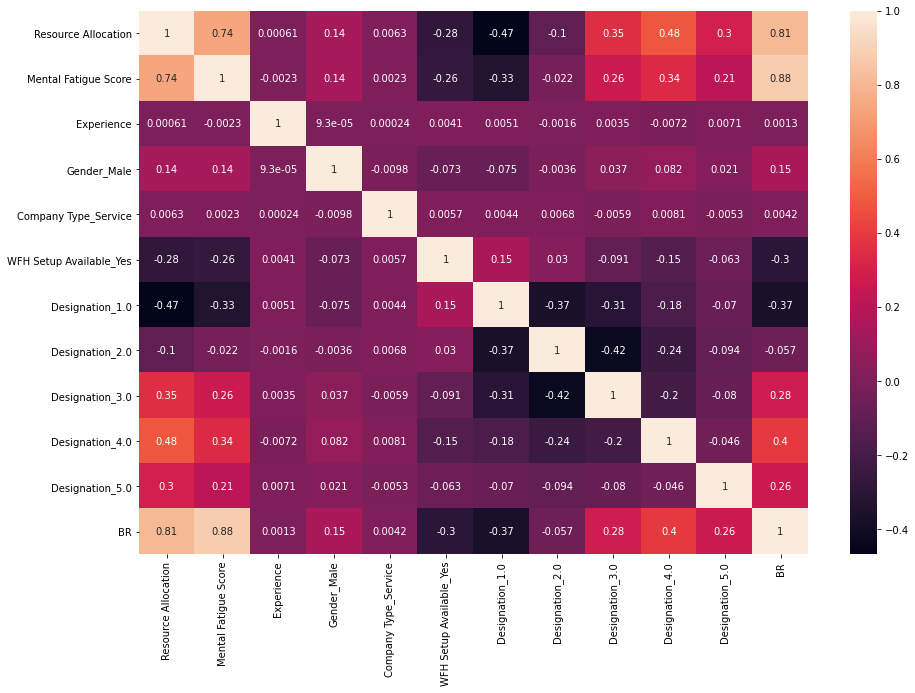

In [22]:
## Correlation
df = X_categorical.iloc[:22750,:]
df['BR']=burn_rate1
correl = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correl,annot=True)

In [23]:
X_categorical.drop(['WFH Setup Available_Yes','Designation_1.0','Designation_2.0','Experience','Company Type_Service'],axis=1,inplace=True)

In [24]:

from sklearn.preprocessing import StandardScaler
X_cat_norm = StandardScaler().fit_transform(X_categorical)
X_cat_norm[1]

array([-1.22241381, -0.39569327,  1.04999092, -0.5998368 , -0.3422053 ,
       -0.13128162])

In [25]:
X_train = X_cat_norm[:22750,:]
X_test  = X_cat_norm[22750:,:]

In [26]:
burn_rate1=burn_rate1.to_numpy()

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, burn_rate1, test_size=0.2)
print(x_train.shape, x_test.shape)

(18200, 6) (4550, 6)


In [28]:
np.any(np.isnan(X_test))

False

In [217]:
## GridSearchCV ----> Useless here
from sklearn.model_selection import GridSearchCV, cross_val_score
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5], 'learning_rate':[0.1,0.01,0.001]
        }
gs = GridSearchCV(model, param_grid = params, scoring='r2', cv=10)
gs = gs.fit(x_train,y_train)


In [49]:
gs.best_score_

0.8518940862207736

In [50]:
gs.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 1.0}

In [83]:
## PCA,KernelPCA---->Failed
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=7,kernel='rbf')
x_train_pcafied = pca.fit_transform(x_train)
x_test_pcafied = pca.transform(x_test)


In [96]:
print(x_train.shape,x_test.shape)

(18200, 10) (4550, 10)


In [122]:
##Univariate Feature Selection ---> worked but didn't optimise
from sklearn.feature_selection import chi2,SelectKBest,f_classif
skb = SelectKBest( f_classif,k = 4)
x_train_pcafied = skb.fit_transform(x_train,y_train)
x_test_pcafied = skb.transform(x_test)


In [123]:
X_test_pcafied = skb.transform(X_test)

In [34]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor(max_depth=3,learning_rate=0.1,n_estimators=1000,reg_alpha=0.001,reg_lambda=0.000001,n_jobs=-1,min_child_weight=3)  ##colsample_bytree=1.0,gamma=0.5,learning_rate=0.1,max_depth=5,min_child_weight=1,subsample=1.0
model_xgb.fit(x_train,y_train)
xgb_train=model_xgb.predict(x_test)

[17:49:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [35]:
from sklearn.model_selection import cross_val_score
cvs  = cross_val_score(model_xgb, x_train, y_train, cv=10, scoring='r2')
print(cvs.mean(),cvs.std())

[17:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [36]:
from sklearn.metrics import r2_score
print(np.sqrt(mean_squared_error(y_test,xgb_train)))
r2_score(xgb_train,y_test)

0.07288425948752375


0.8281400599058784

In [38]:
## Random Forest
from sklearn.ensemble import RandomForestRegressor
model_rfr = RandomForestRegressor(n_estimators=300)
model_rfr = model_rfr.fit(x_train,y_train)
rfr_train = model_rfr.predict(x_test)
from sklearn.model_selection import cross_val_score
cvs  = cross_val_score(model_rfr, x_train, y_train, cv=10, scoring='r2')
print(cvs.mean(),cvs.std())
print(np.sqrt(mean_squared_error(y_test,rfr_train)))
r2_score(rfr_train,y_test)

0.8486396511673974 0.006186933974343935
0.07482004932206063


0.8207768152400413

In [265]:
## SVR
from sklearn.svm import SVR
model_svr = SVR(kernel='rbf')
model_svr = model_svr.fit(x_train,y_train)
svr_train = model_svr.predict(x_test)
from sklearn.model_selection import cross_val_score
cvs  = cross_val_score(model_svr, x_train, y_train, cv=10, scoring='r2')
print(cvs.mean(),cvs.std())
print(np.sqrt(mean_squared_error(y_test,svr_train)))
r2_score(svr_train,y_test)

0.8452507339079733 0.009257392788934414
0.0765589730191159


0.8139093895745244

In [266]:
## Linear Regression 
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr = model_lr.fit(x_train,y_train)
lr_train = model_lr.predict(x_test)
from sklearn.model_selection import cross_val_score
cvs  = cross_val_score(model_lr, x_train, y_train, cv=10, scoring='r2')
print(cvs.mean(),cvs.std())
print(np.sqrt(mean_squared_error(y_test,lr_train)))
r2_score(lr_train,y_test)

0.8319684988994676 0.010327852996021068
0.08088783317431114


0.7868804076827232

In [33]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.1, n_estimators=500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb = model_lgb.fit(x_train,y_train)
lgb_train = model_lgb.predict(x_test)
from sklearn.model_selection import cross_val_score
cvs  = cross_val_score(model_lgb, x_train, y_train, cv=10, scoring='r2')
print(cvs.mean(),cvs.std())
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test,lgb_train)))
r2_score(lgb_train,y_test)

0.8305203478675753 0.007089298297110522
0.0792471356368736


0.7862269955789053

In [283]:
## LassoCV
from sklearn.linear_model import Lasso, LassoCV, RidgeCV
model_lasso = LassoCV(alphas = [1, 0.1,0.05, 0.001, 0.0005], selection='random', max_iter=15000)
model_lasso = model_lasso.fit(x_train,y_train)
lasso_train = model_lasso.predict(x_test)
from sklearn.model_selection import cross_val_score
cvs  = cross_val_score(model_lasso, x_train, y_train, cv=10, scoring='r2')
print(cvs.mean(),cvs.std())
print(np.sqrt(mean_squared_error(y_test,lasso_train)))
r2_score(lasso_train,y_test)

0.8319437659552005 0.010257015293288681
0.08089339532289216


0.7856014394386375

In [48]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)




In [50]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.0798 (0.0014)

ElasticNet score: 0.0798 (0.0014)

Kernel Ridge score: 0.0779 (0.0008)

Gradient Boosting score: 0.0729 (0.0006)

Xgboost score: 0.0737 (0.0007)

LGBM score: 0.0800 (0.0011)



In [51]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [52]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.0727 (0.0006)


In [71]:
stacked_averaged_models = stacked_averaged_models.fit(X_train, burn_rate1)
y_pred_stacked = stacked_averaged_models.predict(X_test)




In [72]:
model_xgb = model_xgb.fit(X_train, burn_rate1)
y_pred_xgb = model_xgb.predict(X_test)


In [80]:
model_rfr = model_rfr.fit(X_train, burn_rate1)
y_pred_rfr = model_rfr.predict(X_test)

In [57]:
y_pred_stacked = stacked_averaged_models.predict(X_test)

In [59]:
y_pred_xgb = model_xgb.predict(X_test)

In [65]:
y_pred_rfr = model_rfr.predict(X_test)

In [62]:
from sklearn.metrics import mean_squared_error
hybrid_train = 0.1*xgb_train + 0.9*stacked_train
print(np.sqrt(mean_squared_error(y_test,hybrid_train)))
print(r2_score(y_test, hybrid_train))

0.07233447052077488
0.855806007915248


In [85]:
#y_pred_xgb = model_xgb.predict(X_test)
#y_pred_rfr = model_rfr.predict(X_test)
#y_pred_stacked = model_stacked.predict(X_test)
#y_pred_lasso =model_lasso.predict(X_test)
ensembled =  0.3*y_pred_xgb + 0.6*y_pred_stacked + 0.1*y_pred_rfr

In [86]:
result  = pd.Series(ensembled)
submission  = pd.concat([employee_id,result],axis=1)
submission.columns=['Employee ID', 'Burn Rate']
submission.to_csv('submission40.csv',index=False)